In [1]:
#Import required libraries: These libraries need be installed in the activated environment!
import math
import numpy as np
import pandas as pd
import scipy.stats
from scipy.stats import norm
import random
import time
import matplotlib
import matplotlib.pyplot as plt
#matplotlib.use("pgf")
#matplotlib.rcParams.update({
#    "pgf.texsystem": "pdflatex",
#    'font.family': 'serif',
#    'text.usetex': True,
#    'pgf.rcfonts': False,
#})
import sys
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers

sys.path.append("..")

[-2.         -1.8974359  -1.79487179 -1.69230769 -1.58974359 -1.48717949
 -1.38461538 -1.28205128 -1.17948718 -1.07692308 -0.97435897 -0.87179487
 -0.76923077 -0.66666667 -0.56410256 -0.46153846 -0.35897436 -0.25641026
 -0.15384615 -0.05128205  0.05128205  0.15384615  0.25641026  0.35897436
  0.46153846  0.56410256  0.66666667  0.76923077  0.87179487  0.97435897
  1.07692308  1.17948718  1.28205128  1.38461538  1.48717949  1.58974359
  1.69230769  1.79487179  1.8974359   2.        ]
Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
batch_normalization (BatchNo (None, 1)                 4         
_________________________________________________________________
h-layer1 (Dense)             (None, 512)               1024      
_________________________________________________________________
batch_normalization_1 (Batch (None, 512)               2048      
______________________________

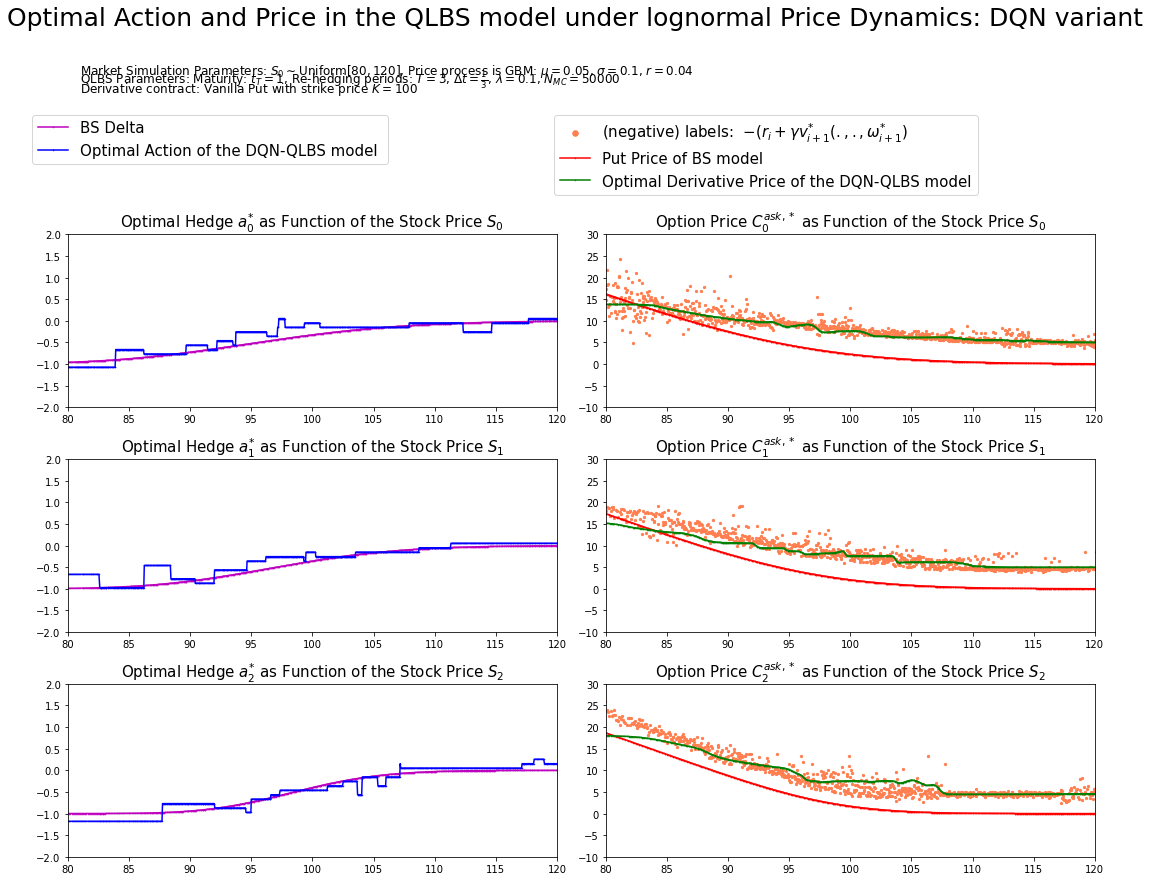

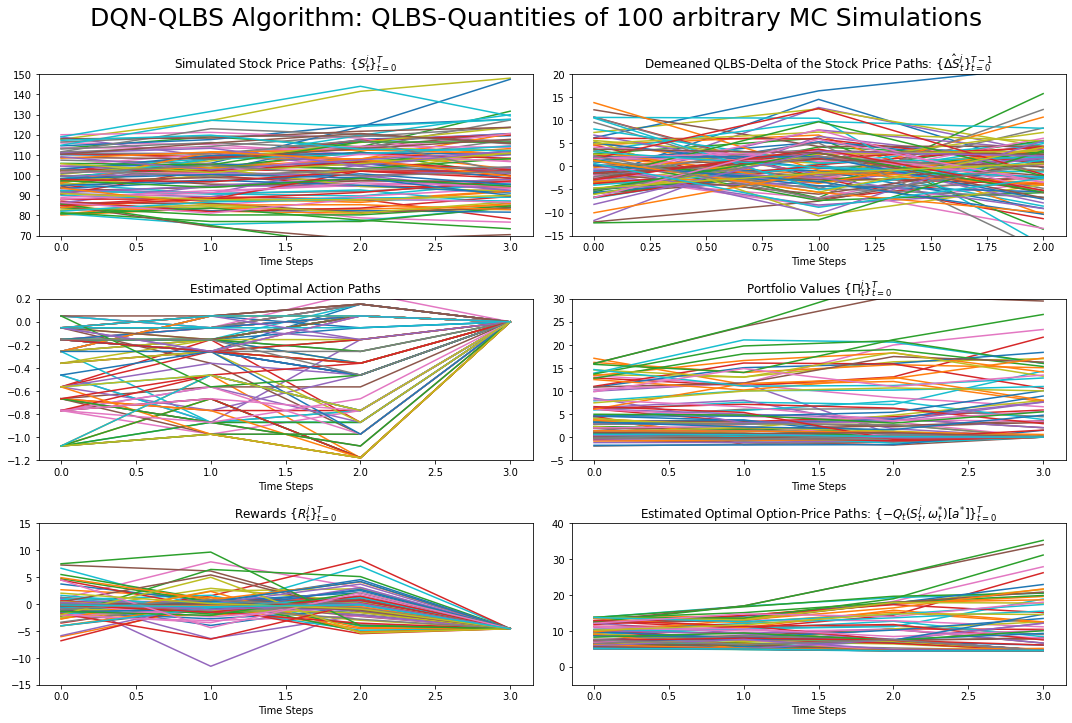

In [2]:
#Initialize parameter values:
mu = 0.05     # drift
r = 0.04      # risk-free rate
sigma = 0.1  # volatility
Ma = 1         # maturity
T = 3        # number of time steps -->weekly re-hedging
delta_t = Ma / T  #time between re-hedging periods
MC = 20000  # number of paths
gamma = np.exp(- r * delta_t)  # discount factor
lambda_par = 0.1 # risk aversion
K = 100             # option stike
#---------------------------------------------------------------------------------------------------------
#Define Call- and Put functions/any European derivative to be priced here:
#Also, define BS Quantities to check convergence of the algorithm
def payoff_put(ST, K):
    """"
    ST is maturity-stock price and K is strike
    """
    return max(K - ST, 0)

def payoff_call(ST, K):
    """"
    ST is maturity-stock price and K is strike
    """
    return max(ST - K, 0)

def payoffvec(ST,K):
    out = np.column_stack((K-ST,np.zeros((len(ST),1)))).max(axis = 1)
    return out

def EuCall_BlackScholes(t,S_t, r=r, sigma=sigma, T=Ma, K=K):
    d_1 = (math.log(S_t / K) + (r + 1 / 2 * math.pow(sigma, 2)) * (T-t)) / (sigma * math.sqrt(T-t))
    d_2 = d_1 - sigma * math.sqrt(T-t)
    phi = scipy.stats.norm.cdf(d_1)
    C = S_t * phi - K * math.exp(-r * (T-t)) * scipy.stats.norm.cdf(d_2)
    return C
def EuPut_BlackScholes(t,S_t, r=r, sigma=sigma, T=Ma, K=K):
    d_1 = (math.log(S_t / K) + (r + 1 / 2 * math.pow(sigma, 2)) * (T-t)) / (sigma * math.sqrt(T-t))
    d_2 = d_1 - sigma * math.sqrt(T-t)    
    phi = scipy.stats.norm.cdf(-d_2)
    C = K * np.exp(-r * (T-t)) * phi - S_t * scipy.stats.norm.cdf(-d_1)
    return C

def EuPut_BlackScholes_Delta(t,S_t, r=r, sigma=sigma, T=Ma, K=K):
    d_1 = (math.log(S_t / K) + (r + 1 / 2 * math.pow(sigma, 2)) * (T-t)) / (sigma * math.sqrt(T-t))
    return scipy.stats.norm.cdf(d_1) - 1
    
    
def EuCall_BlackScholes_Delta(t,S_t, r=r, sigma=sigma, T=Ma, K=K):
    d_1 = (math.log(S_t / K) + (r + 1 / 2 * math.pow(sigma, 2)) * (T-t)) / (sigma * math.sqrt(T-t))
    return scipy.stats.norm.cdf(d_1) 
#--------------------------------------------------------------------------------------------------------------------------
#fill MC stock price path relalizations and choose action space discretization:
#initialize array-object (think of it to be a matrix)
S = pd.DataFrame([],index=range(MC),columns=range(T+1)) #frame-dimension: (MC,T+1)

#choose range for start stock prices S_0
S.loc[:,0] = np.random.uniform(low=80, high=120, size=(MC,1))

#Simulate stock prices as GBM: if you want, choose a random seed like np.random.seed(42)
z = pd.DataFrame(np.random.randn(MC,T),index=range(MC),columns=range(1,T+1)) #frame-dimension: (MC,T) of standard normal 

#fill the frame S such that price path realizations under GBM are in rows of S
for t in range(1,T+1): #1,..,T
    S.loc[:,t] = np.multiply(S.loc[:,t-1],np.exp((mu - 1/2 * sigma**2)*delta_t + sigma * np.sqrt(delta_t) * z.loc[:,t])) 

#choose the action space discretization
Acard = 40 #number of points 
action_space = np.linspace(-2, 2, num=Acard) #discretize action space [-2,2]
print(action_space)

#-------------------------------------------------------------------------------------------------------------------------
#Initialize frames and set initial conditions for PF value at maturity, maturity-reward and optimal maturity action as 
#derived in the thesis
R = pd.DataFrame([],index=range(MC),columns=range(T+1)) #empty frame of dimension (N_MC,T+1)
PI = pd.DataFrame([],index=range(MC),columns=range(T+1)) #empty frame of dimension (MC,T+1)
a_star = pd.DataFrame([],index=range(MC),columns=range(0,T+1)) #dimension:(MC,T+1)

#initialize
PI.loc[:,T] = S.loc[:,T].apply(lambda x: payoff_put(x,K)) #apply payoff put elementwise to last column of S (maturity prices)

R.iloc[:,-1] = - lambda_par * np.var(PI.iloc[:,-1],ddof=1) #set maturity reward as discussed in the thesis

a_star.iloc[:,-1] = 0 #set maturity optimal action to zero 


#define and initialize optimal Q value (numpy array for use with tensorflow more appropriate here than pandas frame)
Q_mat = np.zeros((MC,T+1))
#Q_mat[:,T] = np.column_stack((-PI[T] - lambda_par * np.var(PI.iloc[:,-1],ddof=1)).values)
Q_mat[:,T]  = (-PI.loc[:,T] - lambda_par * np.var(PI.loc[:,T], ddof=1)).values

#--------------------------------------------------------------------------------------------------------------------------
#compile the neural networks used in the DQN-QLBS algorithm:

#define DQN for time step T-1
model = keras.Sequential()
model.add(layers.BatchNormalization(input_shape=(1,)))
#model.add(layers.Dropout(0.1)) #can add dropout if you want to test it (should not be combined with batchnorm)
model.add(layers.Dense(2**9, input_shape=(1,), activation='tanh', name = 'h-layer1'))
model.add(layers.BatchNormalization())
model.add(layers.Dense(2**8, activation='tanh', name = 'h-layer2')) 
model.add(layers.BatchNormalization())
model.add(layers.Dense(2**7, activation='tanh', name = 'h-layer3'))
model.add(layers.Dense(Acard, activation='linear',name = 'output-layer'))
# compile the keras model
model.compile(loss='mse', optimizer='Adam')
print(model.summary()) 

#define DQN for time step T-2
model2 = keras.Sequential()
model2.add(layers.BatchNormalization(input_shape=(1,)))
#model.add(layers.Dropout(0.1))
model2.add(layers.Dense(2**9, input_shape=(1,), activation='tanh', name = 'h-layer1'))
model2.add(layers.BatchNormalization())
model2.add(layers.Dense(2**8, activation='tanh', name = 'h-layer2')) 
model2.add(layers.BatchNormalization())
model2.add(layers.Dense(2**7, activation='tanh', name = 'h-layer3'))
model2.add(layers.Dense(Acard, activation='linear',name = 'output-layer'))
# compile the keras model
model2.compile(loss='mse', optimizer='Adam')
print(model2.summary()) 

#define DQN for time step T-3
model3 = keras.Sequential()
model3.add(layers.BatchNormalization(input_shape=(1,)))
#model.add(layers.Dropout(0.1))
model3.add(layers.Dense(2**9, input_shape=(1,), activation='tanh', name = 'h-layer1'))
model3.add(layers.BatchNormalization())
model3.add(layers.Dense(2**8, activation='tanh', name = 'h-layer2')) 
model3.add(layers.BatchNormalization())
model3.add(layers.Dense(2**7, activation='tanh', name = 'h-layer3'))
model3.add(layers.Dense(Acard, activation='linear',name = 'output-layer'))
# compile the keras model
model3.compile(loss='mse', optimizer='Adam')
print(model3.summary()) 

#---------------------------------------------------------------------------------------------------------------------------
#perform algorithm DQN-QLBS

#NEW: T-1
#generate the training data and store it in (x_batch,y_batch):
x_batch, y_batch, R_batch = [], [], [] # store the training data in
for i in range(MC):
    if i % 1000 == 0: print("Simulation {} of {} Simulations in re-hedging period {} has been performed".format(i,MC,T-1))
    ST = S.loc[i,T-1] * np.exp((mu - 1/2 * sigma**2)*delta_t + sigma * np.sqrt(delta_t) * np.random.randn(50,1)) 
    #ind = random.sample(range(50),1)[0]
    y_target = np.zeros((Acard,1))
    R_act = np.zeros((Acard,1))
    x_batch.append(S.loc[i,T-1])
    for j in range(Acard):
        PITmin1 = gamma * (np.column_stack((K-ST,np.zeros((50,1)))).max(axis = 1) - (action_space[j] * (ST - np.exp(r * delta_t)*S.loc[i,T-1])).reshape(-1))
        RTmin1 = gamma * action_space[j] * (S.loc[i,T] - np.exp(r * delta_t) * S.loc[i,T-1]) - lambda_par * np.var(PITmin1,ddof=1)  
        label = RTmin1 + gamma * Q_mat[i,T]
        y_target[j] = label
        R_act[j] = RTmin1
    y_batch.append(y_target)
    R_batch.append(R_act)
#-------------------------------------------------------------------------------------------------------------------------
    
inp = x_batch# not normalized S[T-1]: normalization didn't increase performance
print("Train the DQN of re-hedging period {}".format(T-1))
model.fit(np.array(inp), np.array(y_batch),epochs = 10, batch_size=24, verbose=1, shuffle = True)
#-----------------------------------------------------------------------------------------------------------------------
#predict the maximum of Q-values of step T-1 and store the argmax in a_star in column T-1, compute PF value at T-1
#recover the reward that is associated with the optimal action and store it in R in column T-1

Qsapred = model.predict(np.array(inp), verbose = 1)
Q_mat[:,T-1] = Qsapred.max(axis = 1) 
a_star[T-1] = action_space[np.argmax(Qsapred, axis=1)]
PI[T-1] = gamma * (PI[T] - a_star[T-1]* (S[T] - np.exp(r * delta_t)*S[T-1]))
for i in range(MC):
    R.loc[i,T-1] = R_batch[i][np.where(action_space == a_star[T-1][i])[0][0]]

#-----------------------------------------------------------------------------------------------------------------------
#the same procedure as for T-1 except that more simulation is required to estimate the conditional variance:

#NEW: T-2
x_batch, y_batch, R_batch = [], [], [] # store the training data in

for i in range(MC):
    if i % 1000 == 0: print("Simulation {} of {} Simulations in re-hedging period {} has been performed".format(i,MC,T-2)) 
    #ind = random.sample(range(50),1)[0]
    STmin1 = S.loc[i,T-2] * np.exp((mu - 1/2 * sigma**2)*delta_t + sigma * np.sqrt(delta_t) * np.random.randn(50,1)) 
    ST = STmin1 * np.exp((mu - 1/2 * sigma**2)*delta_t + sigma * np.sqrt(delta_t) * np.random.randn(50,1))
    #STmin1norm = (STmin1 - np.mean(STmin1))/np.sqrt(np.var(STmin1))
    #STnorm = (ST - np.min(ST))/(np.max(ST) - np.min(ST))
    y_target = np.zeros((Acard,1))
    R_act = np.zeros((Acard,1))
    x_batch.append(S.loc[i,T-2])
    QTmin1sa = model.predict(np.array(STmin1), verbose = 0)
    #QTmin1max = QTmin1sa.max(axis = 1) #where needed?

    PITmin1 = gamma * (payoffvec(ST,K) - action_space[np.argmax(QTmin1sa, axis=1)] * (ST - np.exp(r * delta_t)* STmin1).reshape(-1))
    for j in range(Acard):
        PITmin2 = gamma * (PITmin1 - action_space[j] * (STmin1 - np.exp(r * delta_t)* S.loc[i,T-2]).reshape(-1))
        RTmin2 = gamma * action_space[j] * (S.loc[i,T-1] - np.exp(r * delta_t)* S.loc[i,T-2]).reshape(-1) - lambda_par * np.var(PITmin2,ddof=1)
        label = RTmin2 + gamma * Q_mat[i,T-1]
        y_target[j] = label
        R_act[j] = gamma * action_space[j] * (S.loc[i,T-1] - np.exp(r * delta_t)* S.loc[i,T-2]).reshape(-1) - lambda_par * np.var(PITmin2,ddof=1)
    y_batch.append(y_target)
    R_batch.append(R_act)
    
inpu = x_batch
print("Train the DQN of re-hedging period {}".format(T-2))
model2.fit(np.array(inpu), np.array(y_batch),epochs = 10, batch_size=12, verbose=1, shuffle = True)      

Qsapred = model2.predict(np.array(inpu), verbose = 1)
Q_mat[:,T-2] = Qsapred.max(axis = 1) 
a_star[T-2] = action_space[np.argmax(Qsapred, axis=1)]
PI[T-2] = gamma * (PI[T-1] - a_star[T-2]* (S[T-1] - np.exp(r * delta_t)*S[T-2]))
for i in range(MC):
    R.loc[i,T-2] = R_batch[i][np.where(action_space == a_star[T-2][i])[0][0]]

#---------------------------------------------------------------------------------------------------------------------------
#same procedure as explained for T-1 except that now even more simulation is required to estimate the unconditional variance

#NEW: T-3
x_batch, y_batch, R_batch = [], [], [] # store the training data in

for i in range(MC):
    if i % 1000 == 0: print("Simulation {} of {} Simulations in re-hedging period {} has been performed".format(i,MC,T-3)) 
    #ind = random.sample(range(50),1)[0]
    STmin2 = S.loc[i,T-3] * np.exp((mu - 1/2 * sigma**2)*delta_t + sigma * np.sqrt(delta_t) * np.random.randn(50,1)) 
    STmin1 = STmin2 * np.exp((mu - 1/2 * sigma**2)*delta_t + sigma * np.sqrt(delta_t) * np.random.randn(50,1))
    ST = STmin1 * np.exp((mu - 1/2 * sigma**2)*delta_t + sigma * np.sqrt(delta_t) * np.random.randn(50,1))
    
    #STmin1norm = (STmin1 - np.mean(STmin1))/np.sqrt(np.var(STmin1))
    #STnorm = (ST - np.min(ST))/(np.max(ST) - np.min(ST))
    y_target = np.zeros((Acard,1))
    R_act = np.zeros((Acard,1))
    x_batch.append(S.loc[i,T-3])
    QTmin1sa = model.predict(np.array(STmin1), verbose = 0)
    #QTmin1max = QTmin1sa.max(axis = 1)
    
    QTmin2sa = model2.predict(np.array(STmin2), verbose = 0)
    #QTmin2max = QTmin2sa.max(axis = 1)


    PITmin1 = gamma * (payoffvec(ST,K) - action_space[np.argmax(QTmin1sa, axis=1)] * (ST - np.exp(r * delta_t)* STmin1).reshape(-1))
    PITmin2 = gamma * (PITmin1 - action_space[np.argmax(QTmin2sa, axis=1)] * (STmin1 - np.exp(r * delta_t)* STmin2).reshape(-1))
    for j in range(Acard):
        PITmin3 = gamma * (PITmin2 - action_space[j] * (STmin2 - np.exp(r * delta_t)* S.loc[i,T-3]).reshape(-1))
        RTmin3 = gamma * action_space[j] * (S.loc[i,T-2] - np.exp(r * delta_t)* S.loc[i,T-3]).reshape(-1) - lambda_par * np.var(PITmin3,ddof=1)
        label = RTmin3 + gamma * Q_mat[i,T-2]
        y_target[j] = label
        R_act[j] = gamma * action_space[j] * (S.loc[i,T-2] - np.exp(r * delta_t)* S.loc[i,T-3]).reshape(-1) - lambda_par * np.var(PITmin3,ddof=1)
    y_batch.append(y_target)
    R_batch.append(R_act)
    
inpu = x_batch
print("Train the DQN of re-hedging period {}".format(T-3))
model3.fit(np.array(inpu), np.array(y_batch),epochs = 10, batch_size=24, verbose=1, shuffle = True)      

Qsapred = model3.predict(np.array(inpu), verbose = 1)
Q_mat[:,T-3] = Qsapred.max(axis = 1) 
a_star[T-3] = action_space[np.argmax(Qsapred, axis=1)]
PI[T-3] = gamma * (PI[T-2] - a_star[T-3]* (S[T-2] - np.exp(r * delta_t)*S[T-3]))
for i in range(MC):
    R.loc[i,T-3] = R_batch[i][np.where(action_space == a_star[T-3][i])[0][0]]
    
#------------------------------------------------------------------------------------------------------------------------
#create Figures of DQN-QLBS algorithms to illustrate convergence to BS-Quantities
#set number of scatter points to be plotted
plotpoints = 1000

#initialize numpy array to store BS-results in
BSPutDelta = np.empty((plotpoints,3), dtype=float) #6 columns for T multiple of 6
BSPut = np.empty((plotpoints,3), dtype = float)

#choose plotpoints observations out ob MC-data where quantities to be plotted are in the x- and y-axis range
#otherwise there will be problems to import the figure in latex 
test2 = np.logical_and(np.where((-R[0]-gamma * Q_mat[:,1])< 30, True, False).reshape(-1,1), np.where((-R[0]-gamma * Q_mat[:,1])> -10, True, False).reshape(-1,1))
inindex01 = np.where(test2)[0] 
indexobs01 = S[0][inindex01].sort_values().index 

test3 = np.logical_and( np.where((-R[1] - gamma * Q_mat[:,2]) < 30, True,False).reshape(-1,1), np.where((-R[1] - gamma * Q_mat[:,2])> -10, True,False).reshape(-1,1))
inindex02 = np.where(test3)[0] 
indexobs02 = S[1][inindex02].sort_values().index 

test4 = np.logical_and( np.where((-R[2] - gamma * Q_mat[:,3]) < 30, True,False).reshape(-1,1), np.where((-R[2] - gamma * Q_mat[:,3])> -10, True,False).reshape(-1,1))
inindex03 = np.where(test4)[0] 
indexobs03 = S[2][inindex03].sort_values().index 


idx1 = np.round(np.linspace(0, len(indexobs01) - 1 , plotpoints)).astype(int)
idx2= np.round(np.linspace(0, len(indexobs02) - 1 , plotpoints)).astype(int)
idx3 = np.round(np.linspace(0, len(indexobs03) - 1 , plotpoints)).astype(int)

indexobs = indexobs01[idx1]
indexobs2 = indexobs02[idx2]
indexobs3 = indexobs03[idx3]

#compute the respective BS quantities for the plots for each re-hedging step 0,..,T-1:
for t in range(T): 
    time = t * delta_t
    if t == 0: 
        col = 0
        prices = S.iloc[indexobs,0].values
        
    elif t == 1:
        col = 1
        prices = S.iloc[indexobs2,1].values    
    else: 
        col = 2
        prices = S.iloc[indexobs3,2].values
    for i in range(plotpoints):
        BSPutDelta[i,col] = EuPut_BlackScholes_Delta(time, prices[i], r=r, sigma=sigma, T=Ma, K=K)
        BSPut[i,col] = EuPut_BlackScholes(time,prices[i], r=r, sigma=sigma, T=Ma, K=K)
        


fig,ax = plt.subplots(nrows=3,ncols=2,figsize=(15,10))
fig.suptitle(r'Optimal Action and Price in the QLBS model under lognormal Price Dynamics: DQN variant',fontsize=25, x = 0.5, y = 1.22)
#fig.suptitle(r'Optimal Action: BS-Delta $a_{t}^{BS}$ vs. Optimal Hedge in QLBS under B-Splines and GBM',fontsize=20)


ax[0, 0].plot(S.iloc[indexobs,0],BSPutDelta[:,0],color = 'm', label = r'BS Delta',marker='.',markersize=1)
ax[0, 0].plot(S.iloc[indexobs,0],a_star.iloc[indexobs,0],color= 'blue',marker='.',markersize=1, label = r'Optimal Action of the DQN-QLBS model ') 
#ax[0, 0].plot(S_tvec,QLBS_GBM_action[:,0],color = 'green', label =r'BS-Put-Delta + $ \frac{\mu - r}{2\lambda\sigma^{2}S_{t}}$')
ax[0, 0].set_title(r'Optimal Hedge $a_{0}^{*}$ as Function of the Stock Price $S_{0}$',fontsize=15, loc ='center')
ax[0, 0].set_ylim([-2, 2])
ax[0, 0].set_xlim([80, 120])

ax[0, 1].scatter(S.iloc[indexobs,0],-R.iloc[indexobs,0] - gamma * Q_mat[indexobs,1],color = 'coral',marker='o', s=5, label =r'(negative) labels:  $- (r_{i} + \gamma v_{i+1}^{*}(.,.,\omega_{i+1}^{*}) $ ' )
ax[0, 1].plot(S.iloc[indexobs,0],BSPut[:,0],color = 'red', label = r'Put Price of BS model',marker='.',markersize=1)
ax[0, 1].plot(S.iloc[indexobs,0],-Q_mat[indexobs,0],color= 'green',marker='.',markersize=1, label = r'Optimal Derivative Price of the DQN-QLBS model') 
#ax[0, 0].plot(S_tvec,QLBS_GBM_action[:,0],color = 'green', label =r'BS-Put-Delta + $ \frac{\mu - r}{2\lambda\sigma^{2}S_{t}}$')
ax[0, 1].set_title(r'Option Price $C_{0}^{ask,*}$ as Function of the Stock Price $S_{0}$',fontsize=15, loc ='center')
ax[0, 1].set_ylim([-10, 30])
ax[0, 1].set_xlim([80, 120])

ax[1, 0].plot(S.iloc[indexobs2,1],BSPutDelta[:,1],color = 'm', label = r'BS-Put-Delta: $\frac{\partial C}{\partial S_{t}}$',marker='.',markersize=1)
ax[1, 0].plot(S.iloc[indexobs2,1],a_star.iloc[indexobs2,1],color= 'blue',marker='.',markersize=1, label = r'Optimal Action in QLBS using neural networks: $a(.,\theta_{0}^{*})$ ') 
#ax[0, 0].plot(S_tvec,QLBS_GBM_action[:,0],color = 'green', label =r'BS-Put-Delta + $ \frac{\mu - r}{2\lambda\sigma^{2}S_{t}}$')
ax[1, 0].set_title(r'Optimal Hedge $a_{1}^{*}$ as Function of the Stock Price $S_{1}$',fontsize=15, loc ='center')
ax[1, 0].set_ylim([-2, 2])
ax[1, 0].set_xlim([80, 120])


ax[1, 1].scatter(S.iloc[indexobs2,1],-R.iloc[indexobs2,1] - gamma * Q_mat[indexobs2,2],color = 'coral',marker='o', s=5, label =r'(negative) labels:  $- (R_{0} + \gamma V) $ ' )
ax[1, 1].plot(S.iloc[indexobs2,1],BSPut[:,1],color = 'red', label = r'BS-Put-Delta: $\frac{\partial C}{\partial S_{t}}$',marker='.',markersize=1)
ax[1, 1].plot(S.iloc[indexobs2,1],-Q_mat[indexobs2,1],color= 'green',marker='.',markersize=1, label = r'Optimal Derivative Price in QLBS: $C_{0}^{ask,*}$ ') 
#ax[0, 0].plot(S_tvec,QLBS_GBM_action[:,0],color = 'green', label =r'BS-Put-Delta + $ \frac{\mu - r}{2\lambda\sigma^{2}S_{t}}$')
ax[1, 1].set_title(r'Option Price $C_{1}^{ask,*}$ as Function of the Stock Price $S_{1}$',fontsize=15, loc ='center')
ax[1, 1].set_ylim([-10, 30])
ax[1, 1].set_xlim([80, 120])


 
ax[2, 0].plot(S.iloc[indexobs3,2],BSPutDelta[:,2],color = 'm', label = r'BS-Put-Delta: $\frac{\partial C}{\partial S_{t}}$',marker='.',markersize=1)
ax[2, 0].plot(S.iloc[indexobs3,2],a_star.iloc[indexobs3,2],color= 'blue',marker='.',markersize=1, label = r'Optimal Action in QLBS using neural networks: $a(.,\theta_{0}^{*})$ ') 
#ax[0, 0].plot(S_tvec,QLBS_GBM_action[:,0],color = 'green', label =r'BS-Put-Delta + $ \frac{\mu - r}{2\lambda\sigma^{2}S_{t}}$')
ax[2, 0].set_title(r'Optimal Hedge $a_{2}^{*}$ as Function of the Stock Price $S_{2}$',fontsize=15, loc ='center')
ax[2, 0].set_ylim([-2, 2])
ax[2, 0].set_xlim([80, 120])

ax[2, 1].scatter(S.iloc[indexobs3,2],-R.iloc[indexobs3,2] - gamma * Q_mat[indexobs3,3],color = 'coral',marker='o', s=5, label =r'(negative) labels:  $- (R_{0} + \gamma V) $ ' )
ax[2, 1].plot(S.iloc[indexobs3,2],BSPut[:,2],color = 'red', label = r'BS-Put-Delta: $\frac{\partial C}{\partial S_{t}}$',marker='.',markersize=1)
ax[2, 1].plot(S.iloc[indexobs3,2],-Q_mat[indexobs3,2],color= 'green',marker='.',markersize=1, label = r'Optimal Derivative Price in QLBS: $C_{0}^{ask,*}$ ') 
#ax[0, 0].plot(S_tvec,QLBS_GBM_action[:,0],color = 'green', label =r'BS-Put-Delta + $ \frac{\mu - r}{2\lambda\sigma^{2}S_{t}}$')
ax[2, 1].set_title(r'Option Price $C_{2}^{ask,*}$ as Function of the Stock Price $S_{2}$',fontsize=15, loc ='center')
ax[2, 1].set_ylim([-10, 30])
ax[2, 1].set_xlim([80, 120])

handles, labels = ax[0,0].get_legend_handles_labels()
lgnd = fig.legend(handles, labels,  bbox_to_anchor=(-0.266, 0.38, 0.6, 0.7), prop={'size': 15})
lgnd.legendHandles[0]._sizes = [30]
lgnd.legendHandles[1]._sizes = [30]


handles, labels = ax[0,1].get_legend_handles_labels()
lgnd2 = fig.legend(handles, labels,  bbox_to_anchor=(0.2797, 0.38, 0.6, 0.7), prop={'size': 15})
lgnd2.legendHandles[0]._sizes = [30]
lgnd2.legendHandles[1]._sizes = [30]
#lgnd2.legendHandles[2]._sizes = [30]
plt.tight_layout()
plt.text(37, 171.0, r'Market Simulation Parameters: $S_{0}\sim\mathrm{Uniform}[80,120]$, Price process is GBM: $\mu =0.05$, $\sigma = 0.1$, $r=0.04$', fontsize=12)
plt.text(37, 169.0, r'QLBS Parameters: Maturity: $t_{T}=1$, Re-hedging periods: $T=3$, $\Delta t=\frac{1}{3}$, $\lambda = 0.1$, $N_{MC}=50000$', fontsize=12)
plt.text(37, 167.0, r'Derivative contract: Vanilla Put with strike price $K=100$', fontsize=12)

#plt.savefig('DQNpart1.pgf', bbox_inches='tight')

#--------------------------------------------------------------------------------------------------------------------------
#plot the BS quantities of the DQN-QLBS algorithm, that are stored in the DQN code above to produce this figure:

#compute dS from stock price simulations
dS = S.loc[:,1:T].values - np.exp(r * delta_t) * S.loc[:,0:(T-1)].values
dS = pd.DataFrame(data=dS, index=range(MC),columns=range(T))
dS_hat = dS - np.mean(dS,axis=0)

# plot: Simulated data for N MC paths:

N = 100

f, axarr = plt.subplots(3, 2, figsize=(15,10))
f.suptitle(r'DQN-QLBS Algorithm: QLBS-Quantities of 100 arbitrary MC Simulations',fontsize=25, x = 0.5, y = 1)


axarr[0, 0].plot(S.T.iloc[:,list(range(N))], label = r'Stock price paths: $\{S_{t}^{j}\}_{t=0}^{T}$') #[1,2,3,4,5,6,7,8,9,10]
axarr[0, 0].set_xlabel('Time Steps')
axarr[0, 0].set_title(r'Simulated Stock Price Paths: $\{S_{t}^{j}\}_{t=0}^{T}$')
axarr[0, 0].set_ylim([70, 150])

axarr[0, 1].plot(dS_hat.T.iloc[:,list(range(N))], label = r'QLBS-Quantity $\hat{\Delta S}_t$') #[1,2,3,4,5,6,7,8,9,10]
axarr[0, 1].set_xlabel('Time Steps')
axarr[0, 1].set_title(r'Demeaned QLBS-Delta of the Stock Price Paths: $\{\hat{\Delta S}_{t}^{j}\}_{t=0}^{T-1}$')
axarr[0, 1].set_ylim([-15, 20])

axarr[1, 0].plot(a_star.T.iloc[:,list(range(N))]) 
axarr[1, 0].set_xlabel('Time Steps')
axarr[1, 0].set_title(r'Estimated Optimal Action Paths')
axarr[1, 0].set_ylim([-1.2, 0.2])

axarr[1, 1].plot(PI.T.iloc[:,list(range(N))]) 
axarr[1, 1].set_xlabel('Time Steps')
axarr[1, 1].set_title(r'Portfolio Values $\{\Pi_{t}^{j}\}_{t=0}^{T}$')
axarr[1, 1].set_ylim([-5, 30])

axarr[2, 0].plot(R.T.iloc[:,list(range(N))]) 
axarr[2, 0].set_xlabel('Time Steps')
axarr[2, 0].set_title(r'Rewards $\{R_{t}^{j}\}_{t=0}^{T}$') 
axarr[2, 0].set_ylim([-15, 15])

axarr[2, 1].plot(-Q_mat.T[:,list(range(N))]) 
axarr[2, 1].set_xlabel('Time Steps')
axarr[2, 1].set_title(r'Estimated Optimal Option-Price Paths: $\{-Q_{t}(S_{t}^{j},\omega_{t}^{*})[a^{*}]\}_{t=0}^{T}$')
axarr[2, 1].set_ylim([-5, 40])

plt.tight_layout()
#plt.savefig('DQNpart2.pgf', bbox_inches='tight')